# Importo librerias

In [ ]:
!pip install -q segmentation_models_pytorch

# Importo librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import os
import segmentation_models_pytorch as smp
from tqdm import tqdm
import gc
import time
import copy
from collections import defaultdict
from glob import glob

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import torch.optim as optim
from torch.optim import lr_scheduler
from torch.cuda import amp
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch.nn.functional as F

import albumentations as A

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.2 MB/s eta 0:00:00


# Descarga del dataset desde Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
# Cargo mi API Token
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Para poder descargar, me debo inscribir en la competencia
! kaggle competitions download -c 'uw-madison-gi-tract-image-segmentation'

100% 2.29G/2.30G [00:28<00:00, 141MB/s]
100% 2.30G/2.30G [00:28<00:00, 86.1MB/s]


In [ ]:
! mkdir dataset

In [ ]:
! unzip uw-madison-gi-tract-image-segmentation.zip -d dataset

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: dataset/train/case77/case77_day20/scans/slice_0121_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_0122_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_0123_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_0124_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_0125_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_0126_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_0127_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_0128_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_0129_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_0130_266_266_1.50_1.50.png  
  inflating: dataset/train/case77/case77_day20/scans/slice_

In [ ]:
# Defino los paths
path = './dataset/'
train_path = path + 'train'
os.listdir(path)

['train.csv', 'train', 'sample_submission.csv']

In [ ]:
# Leo el csv de entrenamiento
df = pd.read_csv(f'{path}/train.csv')
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [ ]:
print(df.shape)

(115488, 3)


# Configuraciones del Modelo

In [ ]:
class CONFIG:
    seed          = 42
    debug         = False
    model_name    = 'Unet'
    train_bs      = 32
    valid_bs      = train_bs*2
    img_size      = (224, 224)
    epochs        = 20
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    fold_selected = 1
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Exploratory Data Analysis

## Modifico Dataframe

- Creo columnas con el numero de caso, el dia de la imagen y la slice de la imagen

In [ ]:
# Separo la columna id en diferentes columnas: case, day y slice
df['case'] = df['id'].apply(lambda x: x.split('_')[0].replace('case',''))
df['day'] = df['id'].apply(lambda x: x.split('_')[1].replace('day',''))
df['slice'] = df['id'].apply(lambda x: x.split('_')[3])

df.head()

,id,class,segmentation,case,day,slice
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001
2,case123_day20_slice_0001,stomach,NaN,123,20,0001
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002


- Agrego columna con el path al slice

In [ ]:
# Busco todas las imagenes png en la carpeta train y sus subcarpetas
train_images = glob(os.path.join(train_path, "**", "*.png"), recursive=True)

In [ ]:
first_image_path = train_images[0]
x = first_image_path.rsplit("/", 4)[0]

path_partial_list = [os.path.join(x,
                                  "case" + str(df["case"].values[i]),
                                  "case" + str(df["case"].values[i]) + "_" + "day" + str(df["day"].values[i]),
                                  "scans",
                                  "slice_" + str(df["slice"].values[i]))
                     for i in range(df.shape[0])]
df["path_partial"] = path_partial_list

In [ ]:
path_partial_list = [str(image_path.rsplit("_", 4)[0]) for image_path in train_images]

tmp_df = pd.DataFrame({"path_partial": path_partial_list, "path": train_images})

In [ ]:
df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])

In [ ]:
df.head()

,id,class,segmentation,case,day,slice,path
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,./dataset/train/case123/case123_day20/scans/sl...
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,./dataset/train/case123/case123_day20/scans/sl...
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,./dataset/train/case123/case123_day20/scans/sl...
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,./dataset/train/case123/case123_day20/scans/sl...
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,./dataset/train/case123/case123_day20/scans/sl...


- Agrego columnas con el ancho y altura de la imagen

In [ ]:
df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
df.head()

,id,class,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,./dataset/train/case123/case123_day20/scans/sl...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,./dataset/train/case123/case123_day20/scans/sl...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,./dataset/train/case123/case123_day20/scans/sl...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,./dataset/train/case123/case123_day20/scans/sl...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,./dataset/train/case123/case123_day20/scans/sl...,266,266


- Tengo 3 filas para un mismo slice porque estoy etiquetando las 3 clases posibles. Voy a modificar el dataframe para que haya 1 sola fila y 3 columnas que represente esta info: `large_bowel`, `small_bowel` y `stomach`. Estas columnas van a contenter los pixeles encoded con RLE donde se encuentra cada una de estas labels. Además, agrego una columna `count` que indica cuantos organos se encuentran en esa slice.

In [ ]:
# Creo un nuevo dataframe, leyendo 1 cada 3 filas
df_train = pd.DataFrame({'id':df['id'][::3]})

# Creo nuevas columnas para cada clase y guardo los valores de los pixeles donde se encuentra ese organo
df_train['large_bowel'] = df['segmentation'][::3].values
df_train['small_bowel'] = df['segmentation'][1::3].values
df_train['stomach'] = df['segmentation'][2::3].values

# Guardo el resto de las columnas creadas en el primer df
df_train['path'] = df['path'][::3].values
df_train['case'] = df['case'][::3].values
df_train['day'] = df['day'][::3].values
df_train['slice'] = df['slice'][::3].values
df_train['width'] = df['width'][::3].values
df_train['height'] = df['height'][::3].values

# Creo nuevo indice y cambio NaN por string vacio
df_train.reset_index(inplace=True,drop=True)
df_train.fillna('',inplace=True);

# Agrego nueva columna que indica cuantos objetos hay presentes en la imagen (0, 1, 2 o 3)
df_train['count'] = np.sum(df_train.iloc[:,1:4]!='',axis=1).values
df_train.sample(10)

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
21334,case148_day0_slice_0055,,,,./dataset/train/case148/case148_day0/scans/sli...,148,0,0055,360,310,0
8445,case65_day25_slice_0014,,,,./dataset/train/case65/case65_day25/scans/slic...,65,25,0014,266,266,0
10626,case140_day0_slice_0003,,,,./dataset/train/case140/case140_day0/scans/sli...,140,0,0003,266,266,0
4048,case145_day0_slice_0017,,,,./dataset/train/case145/case145_day0/scans/sli...,145,0,0017,360,310,0
1955,case129_day27_slice_0084,44845 10 45204 13 45563 14 45923 15 46282 16 4...,40092 3 40451 6 40810 7 41169 9 41529 9 41888 ...,36507 9 36865 14 37224 18 37583 36 37942 43 38...,./dataset/train/case129/case129_day27/scans/sl...,129,27,0084,360,310,3
21904,case111_day19_slice_0049,,,,./dataset/train/case111/case111_day19/scans/sl...,111,19,0049,266,266,0
38035,case74_day13_slice_0116,20628 4 20892 8 21157 13 21423 17 21688 19 219...,27052 6 27316 10 27581 13 27834 5 27846 15 280...,,./dataset/train/case74/case74_day13/scans/slic...,74,13,0116,266,266,2
6706,case58_day0_slice_0003,,,,./dataset/train/case58/case58_day0/scans/slice...,58,0,0003,266,266,0
749,case77_day18_slice_0030,,,,./dataset/train/case77/case77_day18/scans/slic...,77,18,0030,266,266,0
7847,case114_day15_slice_0136,,,,./dataset/train/case114/case114_day15/scans/sl...,114,15,0136,360,310,0


In [ ]:
# Verifico si hay valores nulos en las clases
for i in range(3):
    column_index = i + 1
    column_name = df_train.columns[column_index]
    has_null_values = df_train[column_name].isnull().any()
    print(f'La columna {column_name} tiene valores nulos? {has_null_values}')

La columna large_bowel tiene valores nulos? False
La columna small_bowel tiene valores nulos? False
La columna stomach tiene valores nulos? False


- Visualizo cantidad de imagenes con 0 objetos, 1 objeto, 2 objetos y 3 objetos.

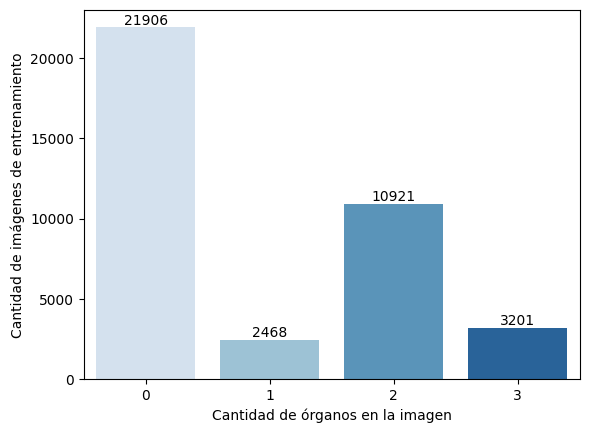

In [ ]:
sns.countplot(x='count', data=df_train, palette='Blues')
plt.xlabel('Cantidad de órganos en la imagen')
plt.ylabel('Cantidad de imágenes de entrenamiento')

count_value_counts = df_train['count'].value_counts().sort_index()
for i, count in enumerate(count_value_counts):
    plt.text(i, count - 10, str(count), ha='center', va='bottom')

plt.show()

- Visualizo cuantas imagenes de entrenamiento tienen una máscara de cada clase

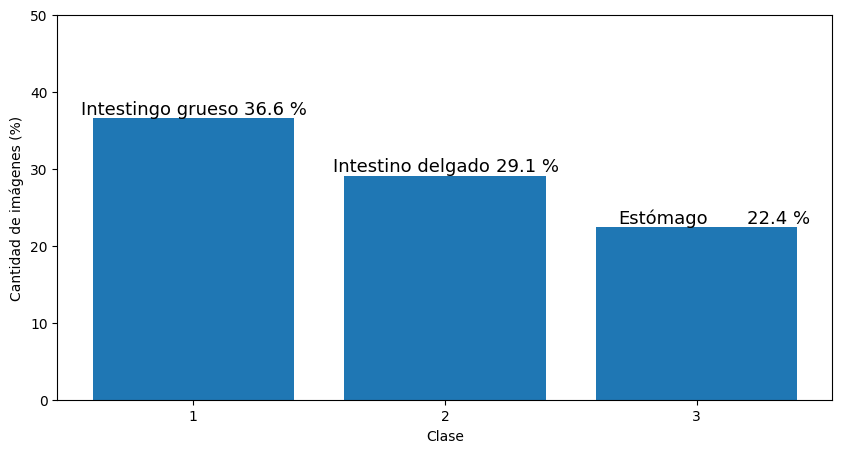

In [ ]:
plt.figure(figsize=(10,5))
bar = plt.bar([1, 2, 3],100*np.mean( df_train.iloc[:,1:4]!='',axis=0))
plt.ylabel('Cantidad de imágenes (%)'); plt.xlabel('Clase')
plt.xticks([1, 2, 3])
labels=['Intestingo grueso','Intestino delgado','Estómago']
for rect, lbl in zip(bar,labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/3, height,  lbl,
             ha='center', va='bottom',fontsize=13)
    plt.text(rect.get_x() + rect.get_width()/1.1, height, '%.1f %%' % height,
             ha='center', va='bottom',fontsize=13)

plt.ylim((0,50)); plt.show()

## Decodificación de las máscaras

Las máscaras se encuentran encodeadas en un formato RLE. Se va a hacer un decoding de estos embeddings para poder visualizar las máscaras sobre las imágenes.

El código es tomado de: [Run-Length Encode and Decode](https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode/script)

In [ ]:
from matplotlib.patches import Rectangle

def rle_decode(mask_rle, shape):
    '''
    Arguments:
    - mask_rle: run-length as string formated (start length)
    - shape: (height, width) of array to return
    Returns:
    - numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    Arguments:
    - img: numpy array, 1 - mask, 0 - background
    Returns:
    - run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    plt.imshow(img, cmap='bone')

    if mask is not None:
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

- Preservo las filas del dataframe que tienen una máscara

In [ ]:
# Agrego indices de mascaras a una lista llamada train_mask
# (las que presentan valores de pixeles en las columnas large_bowel, small_bowel o stomach )
train_mask = list(df_train[df_train['large_bowel']!=''].index)
train_mask += list(df_train[df_train['small_bowel']!=''].index)
train_mask += list(df_train[df_train['stomach']!=''].index)

# Filtro el datraframe y guardo solamente las filas que tienen una máscara
df_train = df_train[df_train.index.isin(train_mask)]
# Reseteo los indices para comenzar en 0 y ser secuenciales
df_train.reset_index(inplace=True, drop=True)
print(f'El dataframe de entrenamiento tiene el shape: {df_train.shape}')

El dataframe de entrenamiento tiene el shape: (16590, 11)


- Creo folds para por utilizar StratifiesKFold

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold

# Inicializo K fold cross validation
skf = StratifiedGroupKFold(n_splits = CONFIG.n_fold,
                           shuffle=True,
                           random_state=42)

# Para cada uno de los 5 splits de skf, asigno un numero de fold a cada set de validación
# basado en el grupo especificado por df_train['case'] (cada caso es un paciente)
for fold, (_, val_idx) in enumerate(skf.split(X=df_train, y=df_train['count'], groups=df_train['case']), 1):
    df_train.loc[val_idx, 'fold'] = fold

# Convierto a uint 8
df_train['fold'] = df_train['fold'].astype(np.uint8)

# Selecciono indices de entrenamiento y validacion
train_ids = df_train[df_train["fold"]!= CONFIG.fold_selected].index
valid_ids = df_train[df_train["fold"]== CONFIG.fold_selected].index

# Agrupo la data de entrenamiento segun el fold al que corresponde e imprimo la
# cantidad de veces que se presenta cada clase
df_train.groupby(['fold', 'count']).size()

fold  count
1     1         621
      2        2259
      3         725
2     1         457
      2        1591
      3         529
3     1         511
      2        2783
      3         682
4     1         422
      2        1942
      3         559
5     1         457
      2        2346
      3         706
dtype: int64

# Dataset

In [ ]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, subset="train", transforms=None):
      self.df = df
      self.subset = subset
      self.transforms = transforms

    def __len__(self):
      return len(self.df)

    def __getitem__(self, index):
      # Defino tamaño de mascara igual al tamaño de las imagenes
      masks = np.zeros((CONFIG.img_size[0], CONFIG.img_size[1], 3), dtype=np.float32)
      img_path = self.df['path'].iloc[index]
      w = self.df['width'].iloc[index]
      h = self.df['height'].iloc[index]
      img = self.__load_img(img_path)
      if self.subset == 'train':
          for k, j in zip([0,1,2], ["large_bowel", "small_bowel", "stomach"]):
              rles = self.df[j].iloc[index]
              # Decoding de la mascara
              mask = rle_decode(rles, shape=(h, w, 1))
              # Resize de la mascara
              mask = cv2.resize(mask, CONFIG.img_size)
              masks[:,:,k] = mask

      masks = masks.transpose(2, 0, 1)
      img = img.transpose(2, 0, 1)

      if self.subset == 'train': return torch.tensor(img), torch.tensor(masks)
      else: return torch.tensor(img)

    def __load_gray_img(self, img_path):
      img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
      # Normalizo
      img = (img - img.min())/(img.max() - img.min())*255.0
      img = cv2.resize(img, CONFIG.img_size)
      img = np.expand_dims(img, axis=-1)
      img = img.astype(np.float32) / 255.0
      return img

    def __load_img(self, img_path):
      img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
      # Normalizo
      img = (img - img.min())/(img.max() - img.min())*255.0
      img = cv2.resize(img, CONFIG.img_size)
      # Gray to rgb
      img = np.tile(img[...,None], [1, 1, 3])
      img = img.astype(np.float32) /255.0
      return img

# Data Augmentation

In [ ]:
data_transforms = {
    "train": A.Compose([
        A.Resize(*CONFIG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.OneOf([
                A.RandomBrightnessContrast(),
                A.RandomGamma(),
                A.RandomBrightness(),
                ], p=0.2),

                ], p=1.0),
    "valid": A.Compose([
        A.Resize(*CONFIG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


# Data Loaders

In [ ]:
# Creo dataset de train y valid
train_dataset = BuildDataset(df_train[df_train.index.isin(train_ids)], transforms=data_transforms['train'])
valid_dataset = BuildDataset(df_train[df_train.index.isin(valid_ids)], transforms=data_transforms['valid'])

# Creo Data Loaders
train_loader = DataLoader(train_dataset, batch_size = CONFIG.train_bs, num_workers=2, shuffle=True, pin_memory=True, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size = CONFIG.valid_bs, num_workers=2, shuffle=False, pin_memory=True)
loaders = {"train": train_loader, "valid": valid_loader}

# Obtengo tamaños de imagen y mascaras
imgs, msks = next(iter(train_loader))
print(f'Tamaño imágenes: {imgs.size()} \nTamaño máscaras: {msks.size()}')

Tamaño imágenes: torch.Size([32, 3, 224, 224]) 
Tamaño máscaras: torch.Size([32, 3, 224, 224])


Visualizo un batch de imagenes + mascaras

In [ ]:
def plot_batch(imgs, msks, size=3):
  plt.figure(figsize=(20, 15))
  for idx in range(size):
      plt.subplot(1, 5, idx+1)
      img = imgs[idx,].permute((1, 2, 0)).numpy()
      msk = msks[idx,].permute((1, 2, 0)).numpy()
      show_img(img, msk)
  plt.tight_layout()
  plt.show()

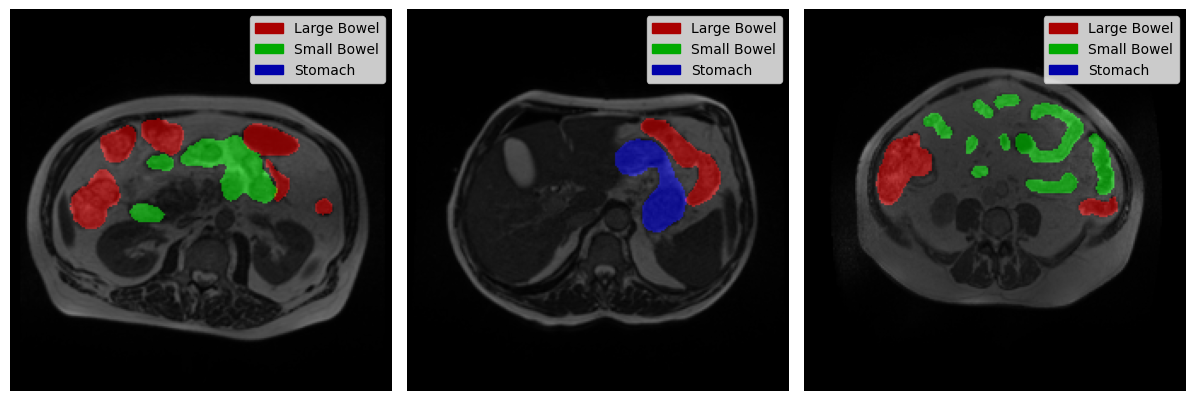

In [ ]:
# Itero sobre los batches de train_loader y obtengo el siguiente batch
imgs, msks = next(iter(train_loader))
# Ploteo las imagenes con sus mascaras
plot_batch(imgs, msks)

In [ ]:
# To release unused memory in idle time use gc.collect()
gc.collect()

7441

# Definicion del modelo

- Modelo: UNet

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
          )

    def forward(self,x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 16 * n_channels)
        self.enc5 = Down(16 * n_channels, 16 * n_channels)

        self.dec1 = Up(32 * n_channels, 8 * n_channels)
        self.dec2 = Up(16 * n_channels, 4 * n_channels)
        self.dec3 = Up(8 * n_channels, 2 * n_channels)
        self.dec4 = Up(4 * n_channels, n_channels)
        self.dec5 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)
        x6 = self.enc5(x5)

        mask = self.dec1(x6, x5)
        mask = self.dec2(mask, x4)
        mask = self.dec3(mask, x3)
        mask = self.dec4(mask, x2)
        mask = self.dec5(mask, x1)
        mask = self.out(mask)
        return mask

In [ ]:
# Creo funcion para crear y cargar el modelo
def build_model():
    model = UNet(in_channels=3, n_classes=3, n_channels=48)
    model.to(CONFIG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

- Defino metricas

In [ ]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.6*BCELoss(y_pred, y_true) + 0.4*DiceLoss(y_pred, y_true)

## Entrenamiento

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()

    dataset_size = 0
    running_loss = 0.0

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)

        batch_size = images.size(0)

        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / CONFIG.n_accumulate

        scaler.scale(loss).backward()

        if (step + 1) % CONFIG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()


            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss

## Validacion

In [ ]:
# Creating a function to perform validation
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()

    dataset_size = 0
    running_loss = 0.0

    val_scores = []

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)

        batch_size = images.size(0)

        y_pred  = model(images)
        loss    = criterion(y_pred, masks)

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss, val_scores

## Entreno la UNet

In [ ]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients

    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler,
                                           dataloader=train_loader,
                                           device= CONFIG.device, epoch=epoch)

        val_loss, val_scores = valid_one_epoch(model, valid_loader,
                                                 device= CONFIG.device,
                                                 epoch=epoch)
        val_dice, val_jaccard = val_scores

        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)

        # Log the metrics


        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')

        # deep copy the model
        if val_dice >= best_dice:
            print(f"Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch

            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved")

        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)

        print(); print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

In [ ]:
def fetch_scheduler(optimizer):
    if CONFIG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max= CONFIG.T_max, eta_min=CONFIG.min_lr)
    elif CONFIG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0 = CONFIG.T_0, eta_min = CONFIG.min_lr)
    elif CONFIG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CONFIG.min_lr,)
    elif CONFIG.scheduler == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CONFIG.scheduler == None:
        return None

    return scheduler

In [ ]:
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=CONFIG.lr, weight_decay=CONFIG.wd)
scheduler = fetch_scheduler(optimizer)

In [ ]:
for fold in range(1):
    print(f'#'*35)
    print(f'######### Fold: {fold}')
    print(f'#'*35)
    model     = build_model()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG.lr, weight_decay=CONFIG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_training(model, optimizer, scheduler,
                                  device= CONFIG.device,
                                  num_epochs= CONFIG.epochs)

###################################
######### Fold: 0
###################################
cuda: Tesla T4

Epoch 1/20

Valid : 100%|██████████| 57/57 [00:32<00:00,  1.77it/s, gpu_memory=6.76 GB, lr=0.00200, valid_loss=0.2353]


Valid Dice: 0.5319 | Valid Jaccard: 0.4520
Valid Score Improved (-inf ---> 0.5319)
Model Saved


Epoch 2/20

Valid : 100%|██████████| 57/57 [00:32<00:00,  1.78it/s, gpu_memory=6.80 GB, lr=0.00199, valid_loss=0.1475]


Valid Dice: 0.7042 | Valid Jaccard: 0.6229
Valid Score Improved (0.5319 ---> 0.7042)
Model Saved


Epoch 3/20

Valid : 100%|██████████| 57/57 [00:31<00:00,  1.79it/s, gpu_memory=6.88 GB, lr=0.00198, valid_loss=0.1300]


Valid Dice: 0.7330 | Valid Jaccard: 0.6548
Valid Score Improved (0.7042 ---> 0.7330)
Model Saved


Epoch 4/20

Valid : 100%|██████████| 57/57 [00:32<00:00,  1.77it/s, gpu_memory=6.88 GB, lr=0.00196, valid_loss=0.1199]


Valid Dice: 0.7583 | Valid Jaccard: 0.6814
Valid Score Improved (0.7330 ---> 0.7583)
Model Saved


Epoch 5/20

Valid : 100%|██████████| 57/57 [00:32<00:00,  1.73it/s, gpu_memory=6.79 GB, lr=0.00194, valid_loss=0.1247]


Valid Dice: 0.7413 | Valid Jaccard: 0.6650


Epoch 6/20

Valid : 100%|██████████| 57/57 [00:31<00:00,  1.78it/s, gpu_memory=6.89 GB, lr=0.00192, valid_loss=0.1248]


Valid Dice: 0.7539 | Valid Jaccard: 0.6769


Epoch 7/20

Valid : 100%|██████████| 57/57 [00:31<00:00,  1.80it/s, gpu_memory=6.85 GB, lr=0.00189, valid_loss=0.1196]


Valid Dice: 0.7550 | Valid Jaccard: 0.6809


Epoch 8/20

Valid : 100%|██████████| 57/57 [00:32<00:00,  1.77it/s, gpu_memory=6.87 GB, lr=0.00186, valid_loss=0.1111]


Valid Dice: 0.7793 | Valid Jaccard: 0.7069
Valid Score Improved (0.7583 ---> 0.7793)
Model Saved


Epoch 9/20

Valid : 100%|██████████| 57/57 [00:31<00:00,  1.81it/s, gpu_memory=6.85 GB, lr=0.00182, valid_loss=0.1208]


Valid Dice: 0.7549 | Valid Jaccard: 0.6799


Epoch 10/20

Valid : 100%|██████████| 57/57 [00:31<00:00,  1.80it/s, gpu_memory=6.87 GB, lr=0.00178, valid_loss=0.1164]


Valid Dice: 0.7752 | Valid Jaccard: 0.7018


Epoch 11/20

Valid : 100%|██████████| 57/57 [00:31<00:00,  1.79it/s, gpu_memory=6.85 GB, lr=0.00173, valid_loss=0.1138]


Valid Dice: 0.7756 | Valid Jaccard: 0.7019


Epoch 12/20

Valid : 100%|██████████| 57/57 [00:31<00:00,  1.80it/s, gpu_memory=6.87 GB, lr=0.00169, valid_loss=0.1153]


Valid Dice: 0.7863 | Valid Jaccard: 0.7133
Valid Score Improved (0.7793 ---> 0.7863)
Model Saved


Epoch 13/20

Valid : 100%|██████████| 57/57 [00:32<00:00,  1.78it/s, gpu_memory=6.85 GB, lr=0.00164, valid_loss=0.1081]


Valid Dice: 0.7872 | Valid Jaccard: 0.7150
Valid Score Improved (0.7863 ---> 0.7872)
Model Saved


Epoch 14/20

Valid : 100%|██████████| 57/57 [00:31<00:00,  1.80it/s, gpu_memory=6.87 GB, lr=0.00158, valid_loss=0.1195]


Valid Dice: 0.7779 | Valid Jaccard: 0.7040


Epoch 15/20

Valid : 100%|██████████| 57/57 [00:31<00:00,  1.79it/s, gpu_memory=6.87 GB, lr=0.00153, valid_loss=0.1260]


Valid Dice: 0.7408 | Valid Jaccard: 0.6662


Epoch 16/20

Valid : 100%|██████████| 57/57 [00:32<00:00,  1.77it/s, gpu_memory=6.87 GB, lr=0.00147, valid_loss=0.1173]


Valid Dice: 0.7798 | Valid Jaccard: 0.7059


Epoch 17/20

Valid : 100%|██████████| 57/57 [00:31<00:00,  1.79it/s, gpu_memory=6.87 GB, lr=0.00141, valid_loss=0.1109]


Valid Dice: 0.7860 | Valid Jaccard: 0.7131


Epoch 18/20

Valid : 100%|██████████| 57/57 [00:31<00:00,  1.79it/s, gpu_memory=6.87 GB, lr=0.00134, valid_loss=0.1160]


Valid Dice: 0.7778 | Valid Jaccard: 0.7044


Epoch 19/20

Valid : 100%|██████████| 57/57 [00:31<00:00,  1.80it/s, gpu_memory=6.87 GB, lr=0.00128, valid_loss=0.1092]


Valid Dice: 0.7973 | Valid Jaccard: 0.7251
Valid Score Improved (0.7872 ---> 0.7973)
Model Saved


Epoch 20/20

Valid : 100%|██████████| 57/57 [00:32<00:00,  1.77it/s, gpu_memory=6.87 GB, lr=0.00121, valid_loss=0.1108]


Valid Dice: 0.7880 | Valid Jaccard: 0.7155


Training complete in 1h 10m 1s
Best Score: 0.7251


- Grafico Dice y IoU en entrenamiento

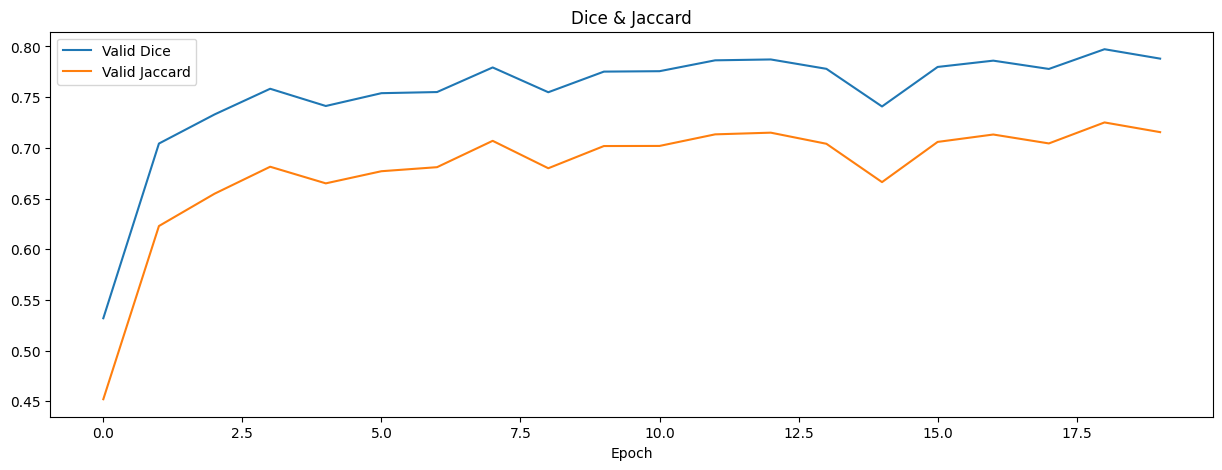

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(CONFIG.epochs),history['Valid Dice'],label='Valid Dice')
plt.plot(range(CONFIG.epochs),history['Valid Jaccard'],label='Valid Jaccard')
plt.title('Dice & Jaccard'); plt.xlabel('Epoch'); plt.ylabel('');plt.legend();
plt.show()

- Grafico loss en entrenamiento

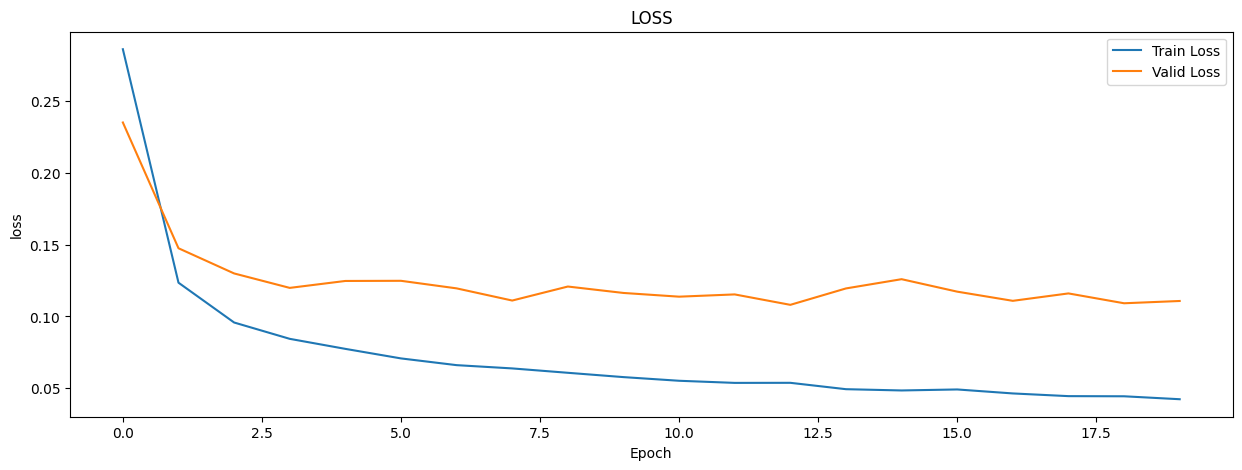

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(CONFIG.epochs),history['Train Loss'],label='Train Loss')
plt.plot(range(CONFIG.epochs),history['Valid Loss'],label='Valid Loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend();
plt.show()

## Predicciones

In [ ]:
test_dataset = BuildDataset(df_train[df_train.index.isin(valid_ids)],
                            transforms=data_transforms['valid'])

test_loader  = DataLoader(test_dataset, batch_size=5,
                          num_workers=4, shuffle=False, pin_memory=True)

imgs, msks =  next(iter(test_loader))

imgs = imgs.to(CONFIG.device, dtype=torch.float)

preds = []
for fold in range(1):
    model = load_model(f"best_epoch-{fold:02d}.bin")
    with torch.no_grad():
        pred = model(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)

imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

- Mascaras

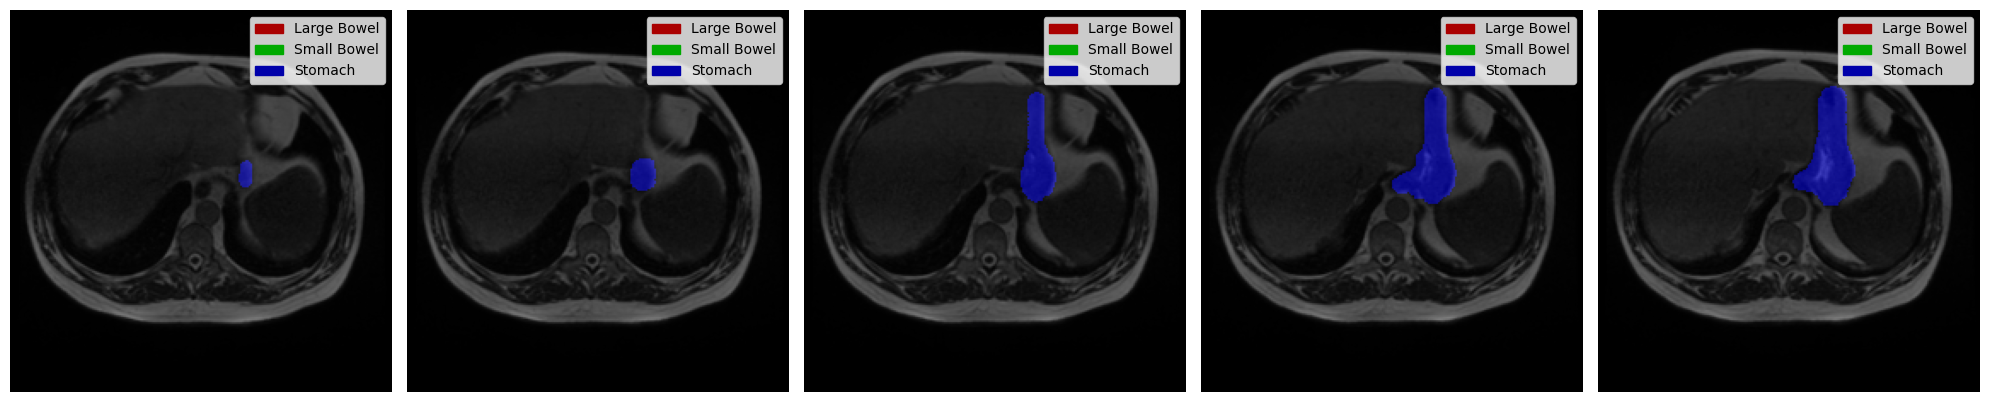

In [ ]:
plot_batch(imgs, msks, size=5)

- Predicciones

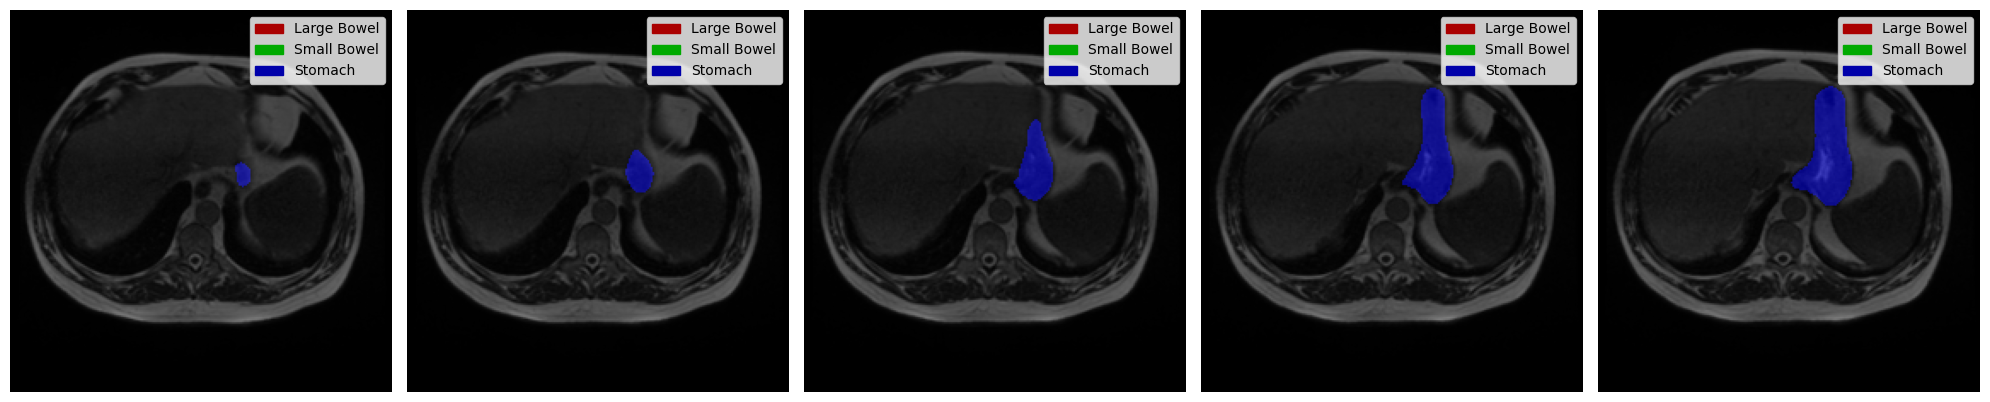

In [ ]:
plot_batch(imgs, preds, size=5)

In [ ]:
test_dataset = BuildDataset(df_train[df_train.index.isin(valid_ids)],
                            transforms=data_transforms['valid'])

test_loader  = DataLoader(test_dataset, batch_size=5,
                          num_workers=4, shuffle=True, pin_memory=True)

imgs, msks =  next(iter(test_loader))

imgs = imgs.to(CONFIG.device, dtype=torch.float)

preds = []
for fold in range(1):
    model = load_model(f"best_epoch-{fold:02d}.bin")
    with torch.no_grad():
        pred = model(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)

imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


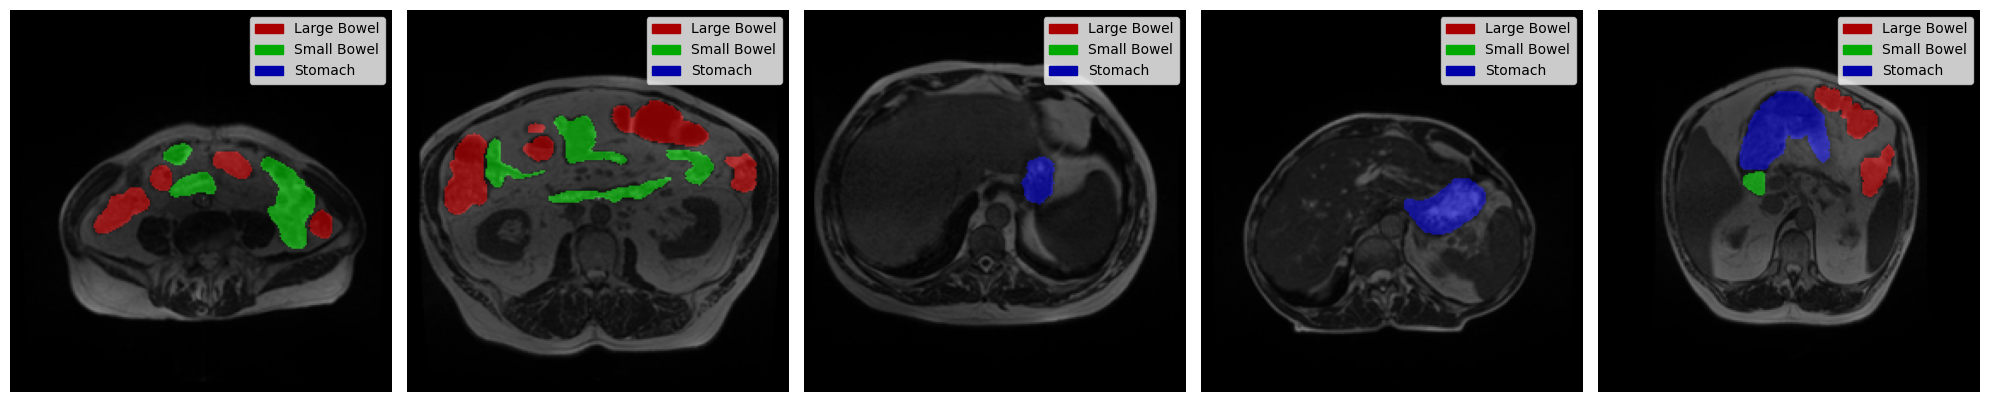

In [ ]:
plot_batch(imgs, msks, size=5)

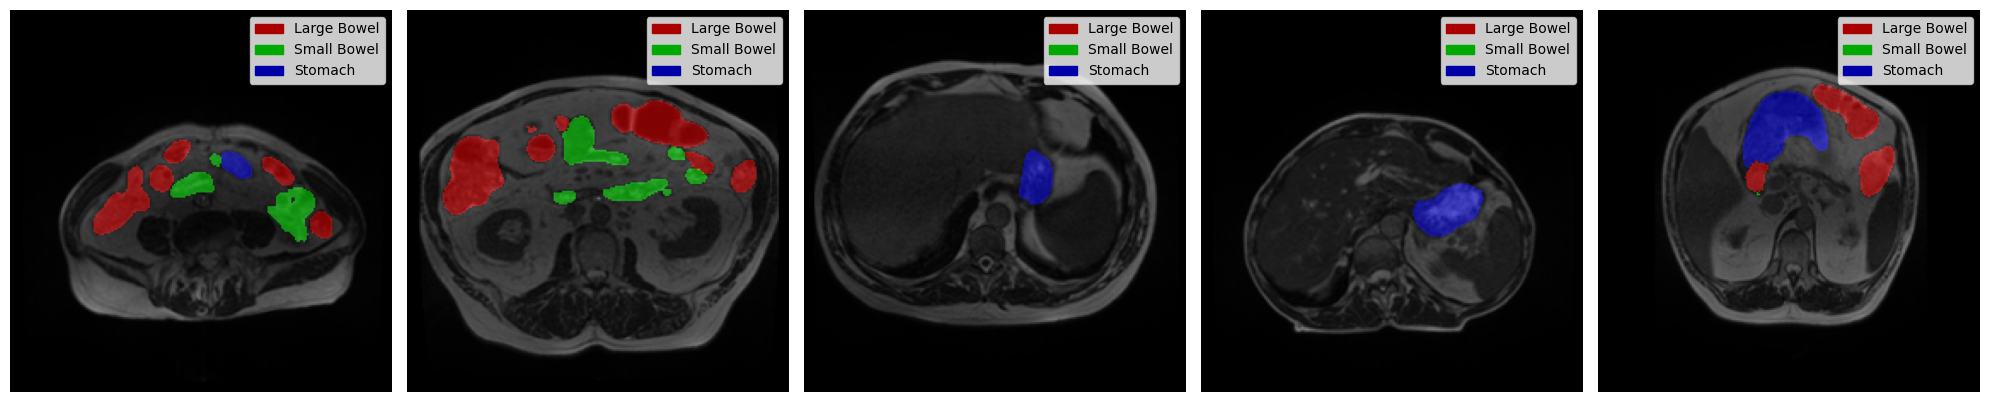

In [ ]:
plot_batch(imgs, preds, size=5)

In [ ]:
test_dataset = BuildDataset(df_train[df_train.index.isin(valid_ids)],
                            transforms=data_transforms['valid'])

test_loader  = DataLoader(test_dataset, batch_size=5,
                          num_workers=4, shuffle=True, pin_memory=True)

imgs, msks =  next(iter(test_loader))
imgs = imgs.to(CONFIG.device, dtype=torch.float)

preds = []
for fold in range(1):
    model = load_model(f"best_epoch-{fold:02d}.bin")
    with torch.no_grad():
        pred = model(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)

imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

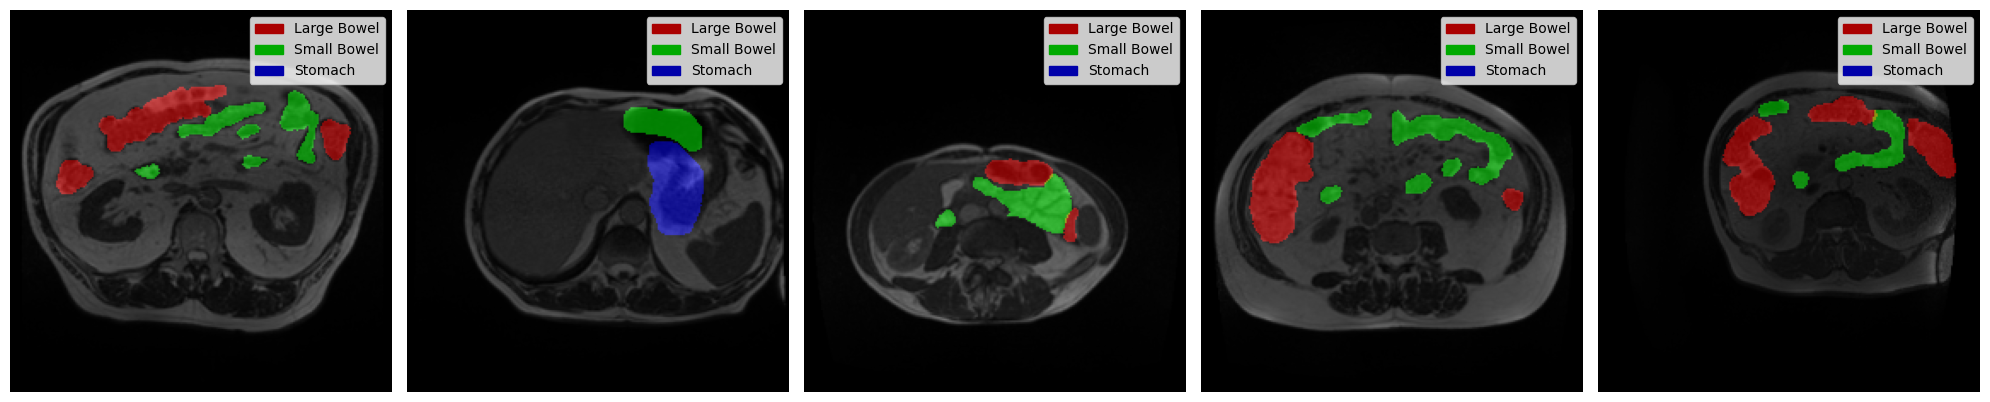

In [ ]:
plot_batch(imgs, msks, size=5)

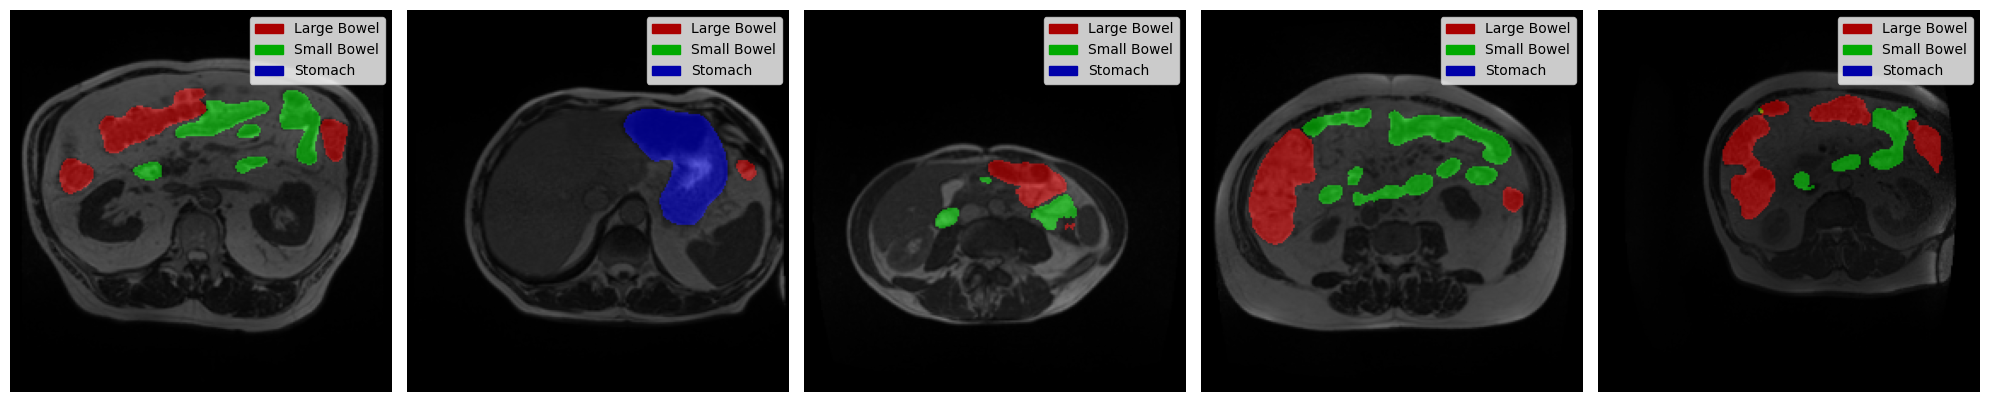

In [ ]:
plot_batch(imgs, preds, size=5)